In [1]:
import sys 
import os 
sys.path.insert(0, "d:\\CAPSTONE\\mlcvnets")

import torch 
from torchvision.io import read_image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.patches as patches

from data import create_train_val_loader
from options.utils import load_config_file
from options.opts import get_training_arguments

from cvnets import get_model
from cvnets.models.detection import build_detection_model
from cvnets.models.classification import arguments_classification, build_classification_model

In [2]:
import sys
sys.argv=['']
del sys 
os.chdir("D:/CAPSTONE/mlcvnets")
os.getcwd()

'D:\\CAPSTONE\\mlcvnets'

In [4]:
opts = get_training_arguments()
setattr(opts, "common.config_file", "config/detection/ssd_mobilevitv3_xx_small_320.yaml")
opts = load_config_file(opts=opts)

setattr(opts, "model.detection.n_classes", 81)
setattr(opts, "dataset.workers", 0)

for key, val in vars(opts).items():
    print(key, ":", val)

sampler.name : batch_sampler
sampler.bs.crop_size_width : 320
sampler.bs.crop_size_height : 320
sampler.vbs.crop_size_width : 256
sampler.vbs.crop_size_height : 256
sampler.vbs.min_crop_size_width : 160
sampler.vbs.max_crop_size_width : 320
sampler.vbs.min_crop_size_height : 160
sampler.vbs.max_crop_size_height : 320
sampler.vbs.max_n_scales : 5
sampler.vbs.check_scale : 32
sampler.vbs.ep_intervals : [40]
sampler.vbs.scale_inc_factor : 0.25
sampler.vbs.scale_inc : False
dataset.root_train : /datasets/coco_2014
dataset.root_val : /datasets/coco_2014
dataset.root_test : 
dataset.name : coco_ssd
dataset.category : detection
dataset.train_batch_size0 : 64
dataset.val_batch_size0 : 64
dataset.eval_batch_size0 : 1
dataset.workers : 0
dataset.persistent_workers : False
dataset.pin_memory : True
dataset.augmentation.gauss_noise_var : None
dataset.augmentation.jpeg_q_range : None
dataset.augmentation.gamma_corr_range : None
dataset.augmentation.blur_kernel_range : None
dataset.augmentation.tran

In [5]:
train_loader, val_loader, train_sampler = create_train_val_loader(opts=opts)

loading annotations into memory...
Done (t=25.53s)
creating index...
index created!
loading annotations into memory...
Done (t=17.44s)
creating index...
index created!
2023-09-21 13:07:29 - LOGS    - Training and validation dataset details: 
COCODetectionSSD(
	root=d:\CAPSTONE\mlcvnets\datasets\coco_2014
	 is_training=True
	samples=59284
	transforms=Compose(
			SSDCroping(), 
			PhotometricDistort(), 
			RandomHorizontalFlip(p=0.5), 
			BoxPercentCoords(), 
			Resize(size=(320, 320), interpolation=bilinear), 
			NumpyToTensor())
)
COCODetectionSSD(
	root=d:\CAPSTONE\mlcvnets\datasets\coco_2014
	 is_training=False
	samples=40504
	transforms=Compose(
			BoxPercentCoords(), 
			Resize(size=(320, 320), interpolation=bilinear), 
			NumpyToTensor())
)
2023-09-21 13:07:29 - LOGS    - Training sampler details: 
BatchSampler(
 	 base_im_size=(h=320, w=320)
 	 base_batch_size=64
	
)
2023-09-21 13:07:29 - LOGS    - Validation sampler details: 
BatchSampler(
 	 base_im_size=(h=320, w=320)
 	 base_

In [26]:
def plot_img(img):
    fig, ax = plt.subplots(1,1)    
    ax.imshow(img)
    plt.show()

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], abs(box[2]-box[0]), abs(box[3]-box[1])
        rect = patches.Rectangle((x,y), width, height,
                                 linewidth=2, edgecolor = 'r', facecolor='none')
        a.add_patch(rect)
    plt.show()


In [6]:
val_loader_1 = next(iter(val_loader))

In [9]:
"""
_ image: torch.Size([64, 3, 320, 320])
_ label: dict(2) 
    +) box_labels : torch.Size([64, 3232])
    +) box_coordinates : torch.Size([64, 3232, 4])
"""
val_loader_1.keys()

dict_keys(['image', 'label'])

In [10]:
max(val_loader_1['label']['box_labels'][0])

tensor(4)

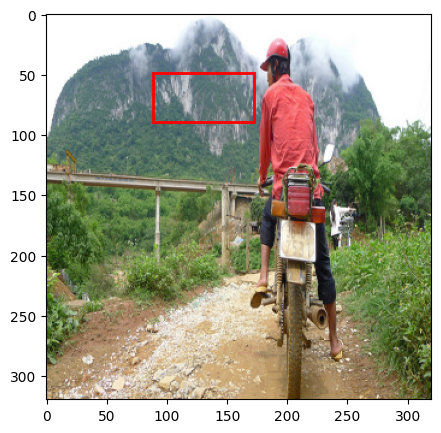

In [27]:
cv2_image = val_loader_1["image"][0].permute(1,2,0)
cv2_image = cv2_image.numpy()
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
cv2_target = {
    'boxes': [val_loader_1['label']['box_coordinates'][0][3].numpy()]
    }
plot_img_bbox(cv2_image, cv2_target)

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
mobilevit = get_model(opts)

2023-09-21 11:56:10 - LOGS    - Pretrained weights are loaded from d:/CAPSTONE/mlcvnets/results/mobilevitv3_xx_small_e300_7098/run_1/checkpoint_ema_best.pt


In [22]:
out = mobilevit.encoder.extract_end_points_all(val_loader_1['image'])

In [27]:
out['out_l5'].shape

torch.Size([64, 128, 10, 10])

In [7]:
mobilevit_cls = build_classification_model(opts=opts)

2023-09-21 13:08:32 - LOGS    - Pretrained weights are loaded from d:/CAPSTONE/mlcvnets/results/mobilevitv3_xx_small_e300_7098/run_1/checkpoint_ema_best.pt


In [29]:
val_loader_1['image'].shape

torch.Size([64, 3, 320, 320])

In [8]:
extract = mobilevit_cls.extract_features(val_loader_1['image'])

In [9]:
extract.shape

torch.Size([64, 512, 10, 10])

In [10]:
extract[0].shape

torch.Size([512, 10, 10])

In [11]:
img_ext = extract[0] #.permute(1,2,0)
img_ext = img_ext.detach().numpy()
img_ext.shape

(512, 10, 10)

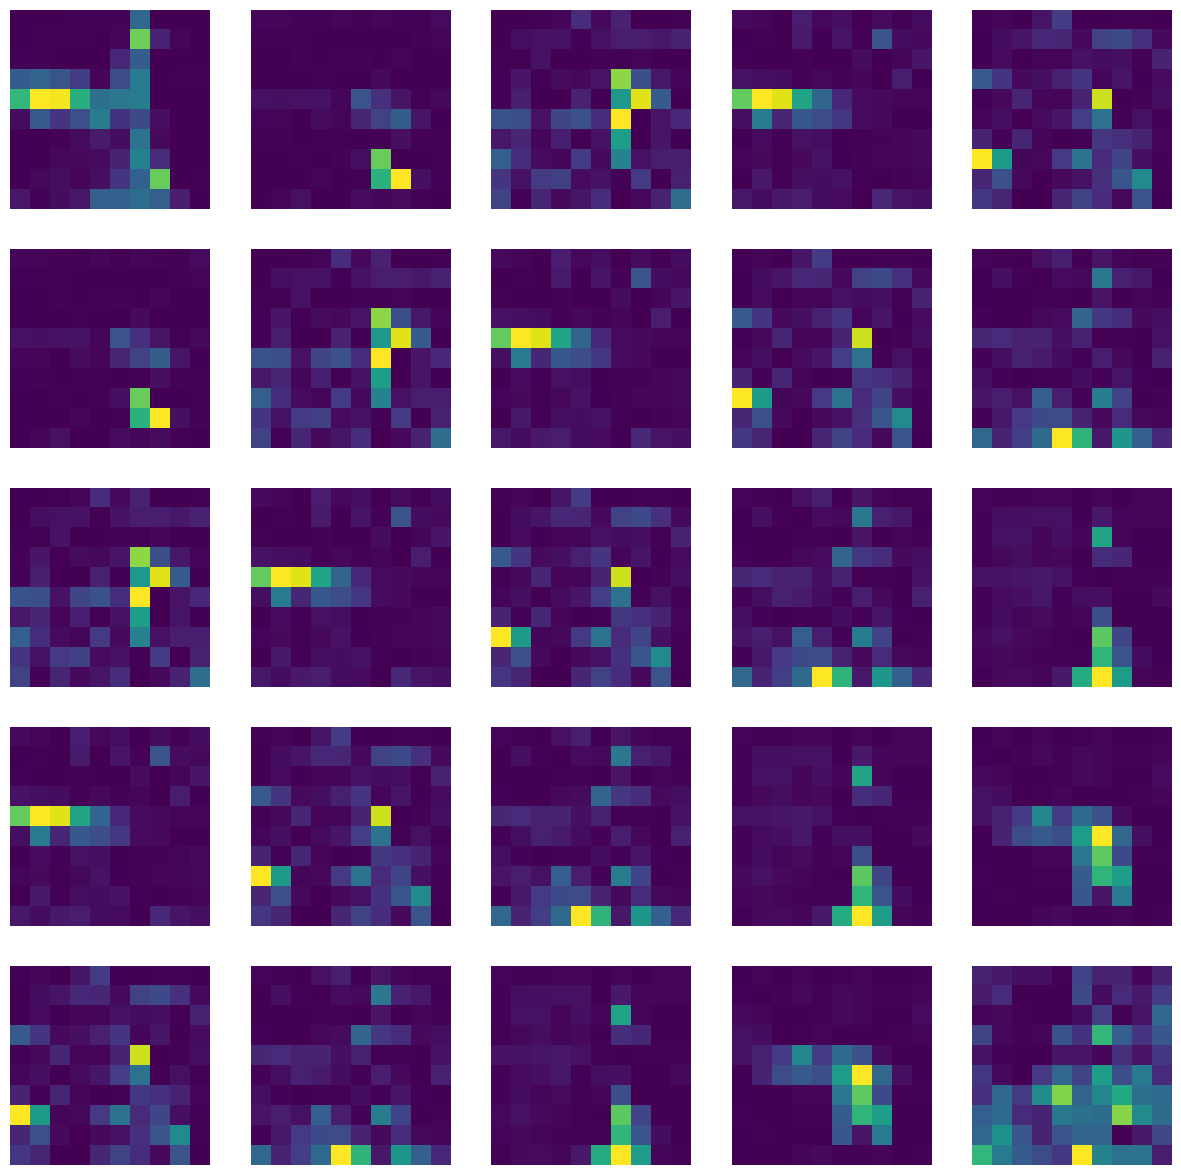

In [24]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
for ridx in range(0,5):
    for cidx in range(0,5): 
        ax[ridx,cidx].imshow(img_ext[ridx+cidx])
        ax[ridx,cidx].axis('off')
plt.show()

In [11]:
PATH = "results/results_detection/mobilevitv3_XXS_coco_e200_1930/checkpoint_ema_best.pt"
full_path = os.path.join(os.getcwd(), PATH)
checkpoint = torch.load(full_path, map_location=device)
mobilevit.load_state_dict(checkpoint)
mobilevit.to(device)

SingleShotDetector(
  (encoder): MobileViTv3(
    (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
    (layer_1): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
    )
    (layer_2): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
      (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
    )
    (layer_3): Sequential(
      (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
      (1): MobileViTv3Block(
      	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
      	patch_h=2, patch_w=2
      	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128, dropout=0.05, ffn_dropout=0.0, attn_dropout=0.0, blocks=2
   

In [12]:
#box_labels, box_coordinates
img, target = val_loader_1['image'], val_loader_1['label']

mobilevit.eval()
with torch.no_grad():
    pred = mobilevit(img.to(device))

In [13]:
pred_label = pred[0]
pred_box = pred[1]

In [14]:
print(pred_label.shape)
print(pred_box.shape)

torch.Size([64, 3232, 81])
torch.Size([64, 3232, 4])


In [15]:
target.keys()

dict_keys(['box_labels', 'box_coordinates'])

In [16]:
target['box_labels'].shape

torch.Size([64, 3232])

In [17]:
indice = torch.argmax(target['box_labels'][0], dim=0)
value = target['box_labels'][0][indice]
print("Index: {}".format(indice))
print("Value: {}".format(value))

Index: 2739
Value: 4


In [18]:
target['box_coordinates'].shape

torch.Size([64, 3232, 4])

In [19]:
pred_label.shape

torch.Size([64, 3232, 81])